In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
from skimage.measure import label, regionprops
from skimage.filters import median
from sklearn.cluster import KMeans
from skimage import io, restoration, color

In [2]:
def segment_lungs(image):
    # Visualise original image.
    plt.imshow(image, cmap="gray")
    plt.title("Original image")
    plt.show()

    # Apply an Otus threshold.
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    plt.imshow(binary, cmap="gray")
    plt.title("Binary image")
    plt.show()

    # Keep 2nd and 3rd largest connected components.
    label_image = label(~binary)
    regions = regionprops(label_image)
    regions.sort(key=lambda x: x.area, reverse=True)
    binary = np.zeros_like(binary)

    # Avoid largest connected component (background).
    binary[label_image == regions[1].label] = 1
    binary[label_image == regions[2].label] = 1

    plt.imshow(binary, cmap="gray")
    plt.title("Binary image with 2 largest connected components (excluding background)")
    plt.show()

    # Fill holes.
    binary = binary_fill_holes(binary)

    plt.imshow(binary, cmap="gray")
    plt.title("Binary image with filled holes")
    plt.show()

    # Visualise the final segmentation over the original image.
    plt.imshow(image, cmap="gray")
    binary = binary.astype(float)
    binary[binary == 0] = np.nan  # Only show the segmented regions.
    plt.imshow(binary, alpha=0.5)
    plt.title("Final segmentation")
    plt.show()

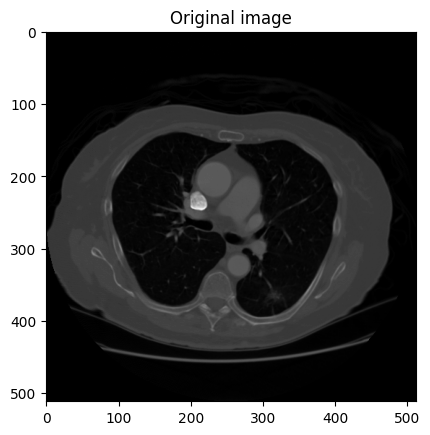

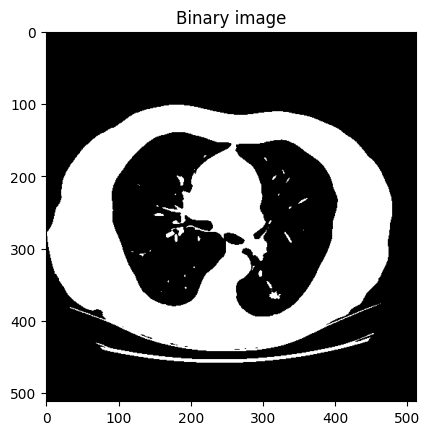

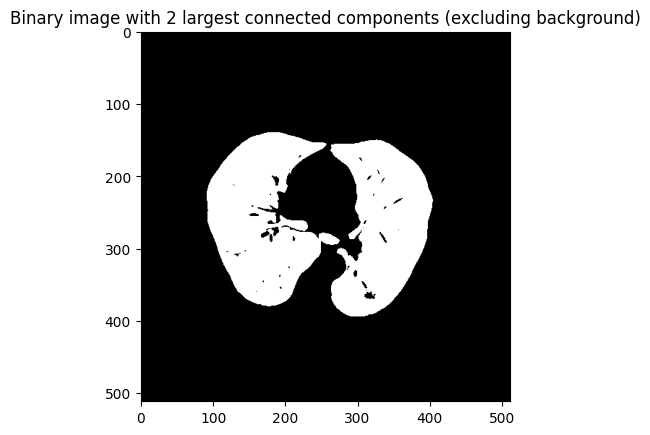

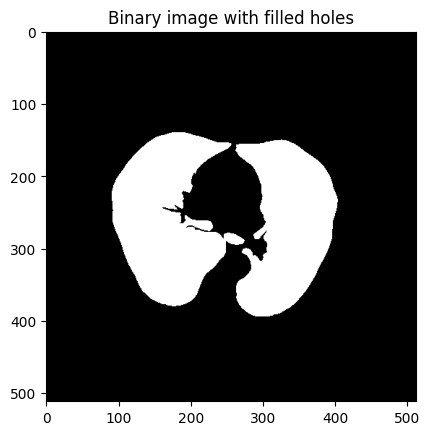

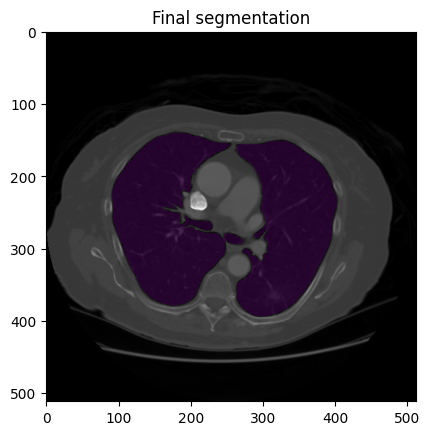

In [3]:
image_path = "data/CT.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
segment_lungs(image)

In [69]:
import numpy as np
import matplotlib.pyplot as plt


def create_rgb_mask(binary_mask):
    # Create an all-white RGB image of the same dimensions as the binary mask
    height, width = binary_mask.shape
    rgb_mask = (
        np.ones((height, width, 3), dtype=np.uint8) * 255
    )  # Multiply by 255 to make it white

    # Where the binary mask is 1, set the RGB mask to black
    rgb_mask[binary_mask == 1] = [0, 0, 0]  # Set to black

    return rgb_mask


def segment_flowers(image):
    from skimage import io, restoration, color

    # Visualise original image.
    plt.imshow(image)
    plt.title("RGB Image")
    plt.axis("off")
    plt.show()

    # Apply a guassian blur to denoise the image.
    denoised_image = restoration.denoise_bilateral(
        image, win_size=5, sigma_color=0.1, sigma_spatial=15, channel_axis=-1
    )

    plt.imshow(denoised_image)
    plt.title("Denoised Image")
    plt.axis("off")
    plt.show()

    # Fit a KMeans model to the image.
    kmeans = KMeans(n_clusters=4)

    # Use LAB colour space for clustering.
    image_lab = color.rgb2lab(denoised_image)
    pixels = image_lab.reshape((-1, 3))

    # Create the KMeans model
    kmeans = KMeans(n_clusters=4)

    # Fit the KMeans model
    kmeans.fit(pixels)

    # Get the cluster assignments
    cluster_assignments = kmeans.labels_

    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_

    # Reshape the cluster assignments to an image
    cluster_image = cluster_assignments.reshape(image_lab.shape[:2])

    # LAB value for purple (source: https://www.e-paint.co.uk/lab-hlc-rgb-lrv-values.asp?cRange=BS+5252&cRef=02+D+45&cDescription=Purple)
    purple = [34.64, 34.45, -4.07]

    # Find the cluster center that is closest to purple.
    closest_cluster_index = np.argmin(np.linalg.norm(cluster_centers - purple, axis=1))

    # Get the mask for the purple cluster.
    mask = cluster_image == closest_cluster_index

    # Perform opening with a ball of radius 2 to disconnect small regions.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)

    # Visualise the mask
    plt.imshow(mask, cmap="gray")
    plt.title("K Means Mask")
    plt.axis("off")
    plt.show()

    # Keep only connected components with area greater than 50 pixels.
    label_image = label(mask)
    regions = regionprops(label_image)
    mask = np.zeros_like(mask)
    for region in regions:
        if region.area > 50:
            mask[label_image == region.label] = 1

    # Binary fill holes to segment more surrounding pixels.
    mask = binary_fill_holes(mask)

    plt.imshow(mask, cmap="gray")
    plt.title("Cleaned Mask")
    plt.axis("off")
    plt.show()

    # Visualize the mask over the original image.
    rgb_mask = create_rgb_mask(mask)
    rgb_mask = rgb_mask.astype(float)
    rgb_mask[rgb_mask == 0] = np.nan  # Set black to transparent.

    # Normalise the mask to avoid clipping when overlaying.
    rgb_mask /= 255.0

    plt.imshow(image)
    plt.imshow(
        rgb_mask, cmap="jet", alpha=0.5
    )  # Use a colormap with good contrast, 'jet' for example
    plt.title("Mask Overlay")
    plt.axis("off")
    plt.show()

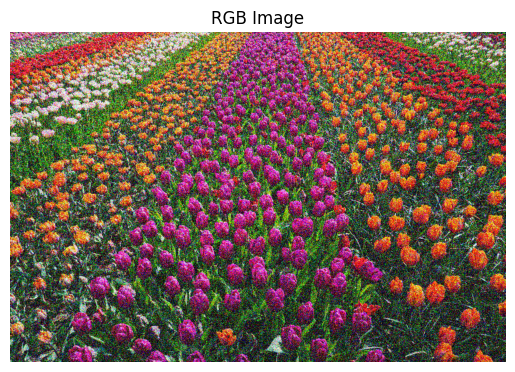

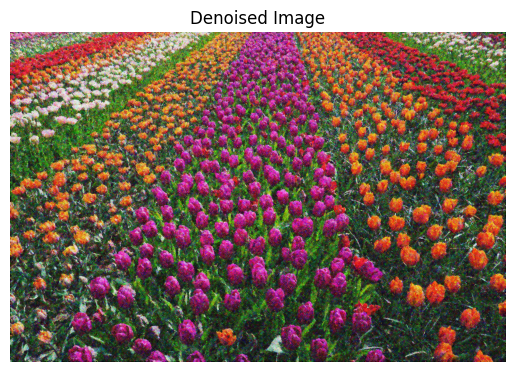

/Users/vishaljain/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


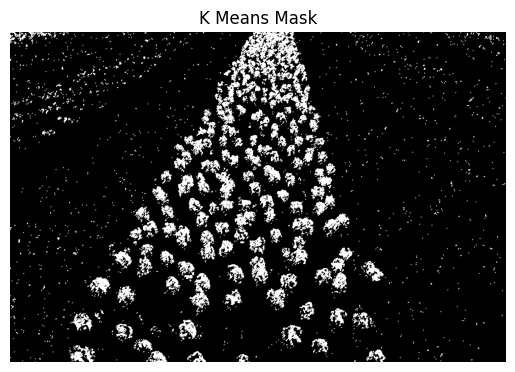

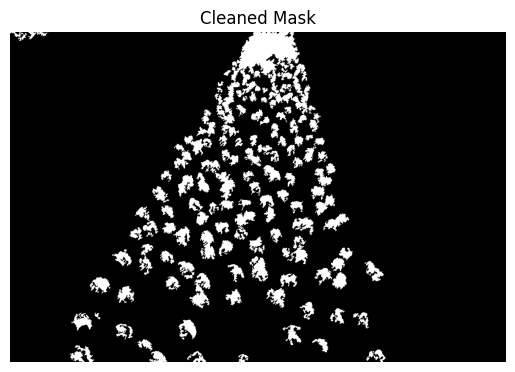

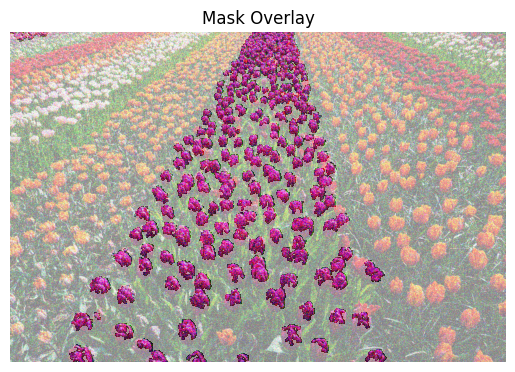

In [70]:
image_path = "data/noisy_flower.jpg"
image = io.imread(image_path)

# RGBA -> RGB since alpha=255 everywhere.
image = image[:, :, :3]
segment_flowers(image)

In [71]:
def segment_coins(image):
    plt.imshow(image, cmap="gray")
    plt.title("0) Original Image")
    plt.axis("off")
    plt.show()

    # Make a copy to avoid modifying the original image.
    img = image.copy()

    # Median filter the intensity row wise to line artifacts.
    row = image[0, :]
    row_median = median(row, np.ones(7))
    for idx in range(1, image.shape[0]):
        row_filtered = median(image[idx, :], np.ones(10))
        img[idx, :] = row_filtered

    plt.imshow(image, cmap="gray")
    plt.title("1) Row Wise Median Filtered Image")
    plt.axis("off")
    plt.show()

    # Apply adaptive thresholding to get a binary image.
    thresh = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 1
    )

    plt.imshow(thresh, cmap="gray")
    plt.title("1) Apply Adaptive Thresholding")
    plt.axis("off")
    plt.show()

    # Applying morphological closing to connect the background.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    plt.imshow(closing, cmap="gray")
    plt.title("2a) Apply Morphological Closing to Connect Background")
    plt.axis("off")
    plt.show()

    # Get the canny edges of the original image to subtract from the closing.
    edges = cv2.Canny(img, 100, 200)

    plt.imshow(edges, cmap="gray")
    plt.title("2b) Get Canny Edges over Original Image")
    plt.axis("off")
    plt.show()

    # Subtract the edges from the closing to disconnect the background from the coins.
    coins = closing - edges

    plt.imshow(coins, cmap="gray")
    plt.title(
        "3) Take Difference Between Closing and Edges to Disconnect Background and Coins"
    )
    plt.axis("off")
    plt.show()

    # Morphological opening to ensure background and foreground are fully disconnected.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opening = cv2.morphologyEx(coins, cv2.MORPH_OPEN, kernel)

    plt.imshow(opening, cmap="gray")
    plt.title("4) Morphological Opening to Fully Disconnect Background and Coins")
    plt.axis("off")
    plt.show()

    # Find connected components.
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        opening, connectivity=8
    )

    # If there are any components, find the largest by area (including the background).
    if num_labels > 1:
        largest_component = 1 + np.argmax(
            stats[1:, cv2.CC_STAT_AREA]
        )  # Adding 1 because we exclude the background
        largest_mask = labels == largest_component

        # Set the largest component to zero (remove it).
        closing[largest_mask] = 0

    plt.imshow(closing, cmap="gray")
    plt.title("5) Removing Background by Removing Largest Connected Component")
    plt.axis("off")
    plt.show()

    # Create a dictionary where key is a region and value is number of pixels in that region.
    labels = label(closing)
    regions = regionprops(labels)
    region_dict = {region.label: region.area for region in regions}

    # View histogram of region sizes.
    plt.hist(region_dict.values(), bins=100)
    plt.xlabel("Region Size")
    plt.ylabel("Frequency")
    plt.title("Histogram of Region Sizes")
    plt.yscale("log")
    plt.show()

    # Remove all regions with less than 100 pixels, found by looking at the histogram.
    for region in regions:
        if region.area < 100:
            labels[labels == region.label] = 0

    # Visualise the result after removing small regions.
    plt.imshow(labels, cmap="nipy_spectral")
    plt.title("6) Remove Small Regions")
    plt.axis("off")
    plt.show()

    # Use a final binary fill holes operation to fill any holes.
    filled = label(binary_fill_holes(labels))

    plt.imshow(filled, cmap="nipy_spectral")
    plt.title("7) Apply Binary Fill Holes")
    plt.axis("off")
    plt.show()

    return filled

In [38]:
def select_coin_segs(labels):
    # Get the region properties of the labels.
    props = regionprops(labels)

    # Get a list of centroid coordinates.
    centroids_i = np.array([region.centroid[0] for region in props])
    centroids_j = np.array([region.centroid[1] for region in props])

    # Find centroid bins that have 6 elements in the x direction and 4 elements in the y direction.
    i_bins = [0]
    j_bins = [0]

    for i in range(0, labels.shape[0], 10):
        l_bin = i_bins[-1]
        r_bin = i

        # Count number of elements in the current bin
        count = centroids_i[(centroids_i >= l_bin) & (centroids_i < r_bin)].shape[0]

        if count == 6:
            i_bins.append(r_bin)

    for j in range(0, labels.shape[1], 10):
        l_bin = j_bins[-1]
        r_bin = j

        # Count number of elements in the current bin
        count = centroids_j[(centroids_j >= l_bin) & (centroids_j < r_bin)].shape[0]

        if count == 4:
            j_bins.append(j)

    # Visualise centroid coordinates and the identified bins.
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
    fig.suptitle("Centroid Coordinates and Identified Bins")
    ax[0].scatter(list(range(len(centroids_i))), centroids_i)
    ax[0].set_title("Centroid i Coordinate scatter")
    for bin_ in i_bins:
        ax[0].axhline(bin_, color="red")

    ax[1].scatter(list(range(len(centroids_j))), centroids_j)
    ax[1].set_title("Centroid j Coordinate scatter")
    for bin_ in j_bins:
        ax[1].axhline(bin_, color="red")

    plt.tight_layout()
    plt.show()

    # Visualise the coins and their identied bin based coordinates.
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(labels, cmap="nipy_spectral")
    ax.set_title("Identified Coins and their i,j coordinates")
    ax.axis("off")

    for region in props:
        i, j = np.digitize(region.centroid[0], i_bins), np.digitize(
            region.centroid[1], j_bins
        )
        ax.text(region.centroid[1], region.centroid[0], f"{i},{j}", color="k")

    plt.show()

    # Only show the coins where i = j.
    for region in props:
        i, j = np.digitize(region.centroid[0], i_bins), np.digitize(
            region.centroid[1], j_bins
        )
        if i != j:
            labels[labels == region.label] = 0

    # Visualize the result after removing coins that do not meet the criteria
    plt.imshow(labels, cmap="nipy_spectral")
    plt.title("8) Select Coins with i = j")
    plt.axis("off")
    plt.show()

    return labels

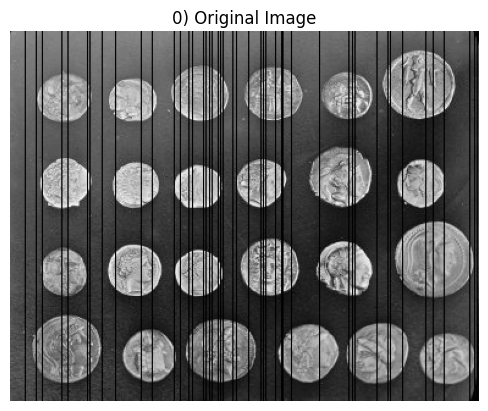

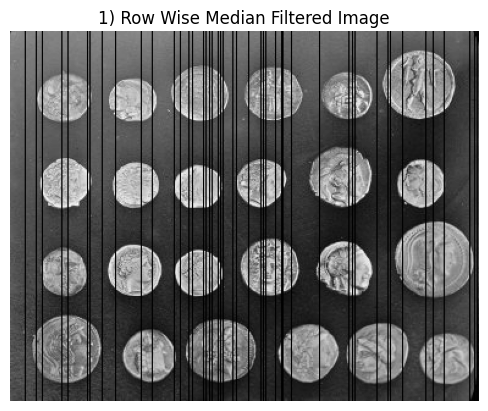

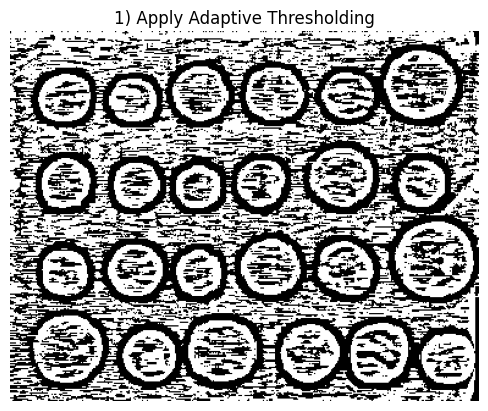

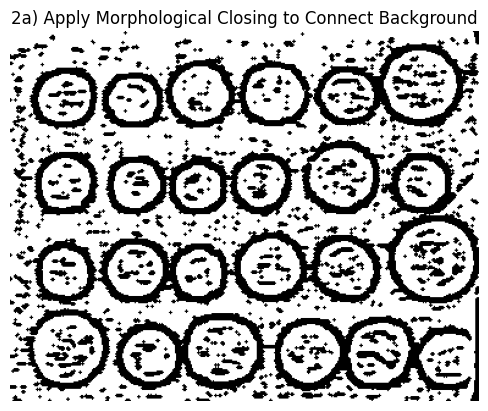

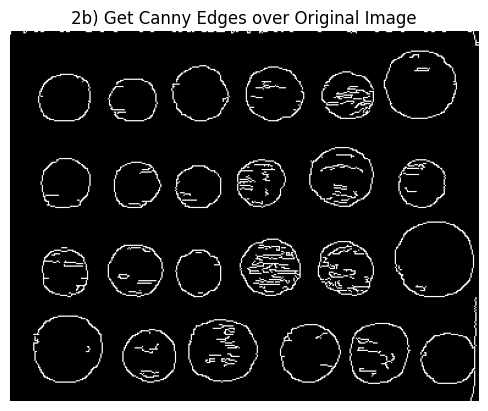

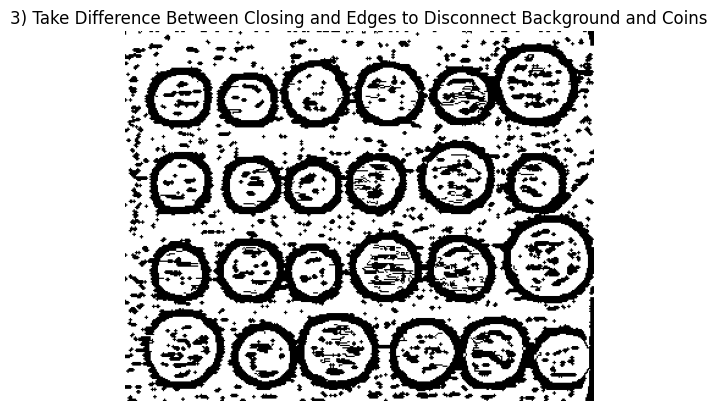

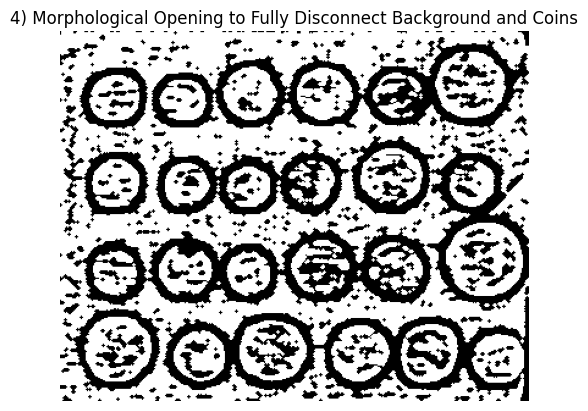

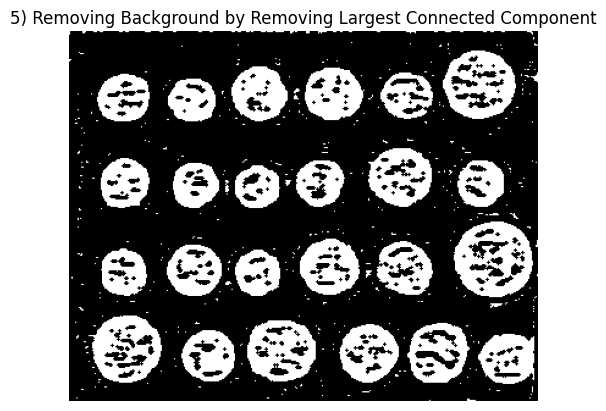

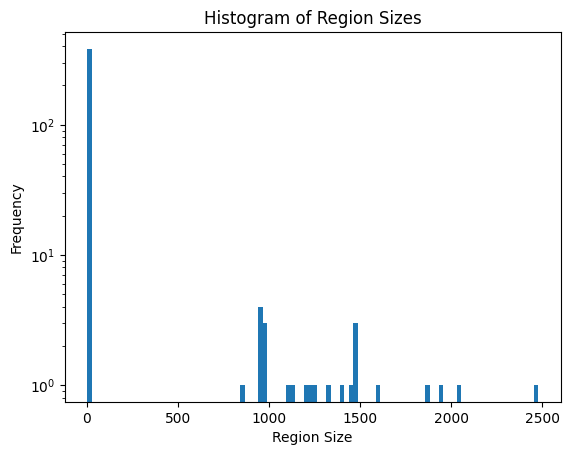

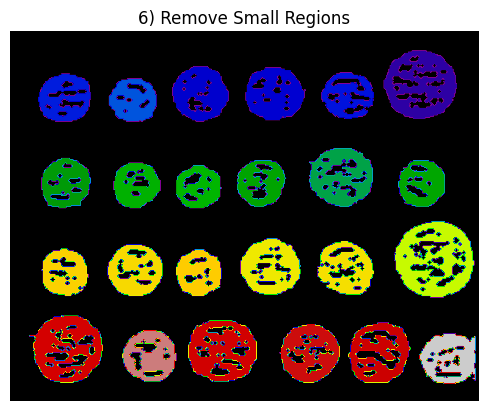

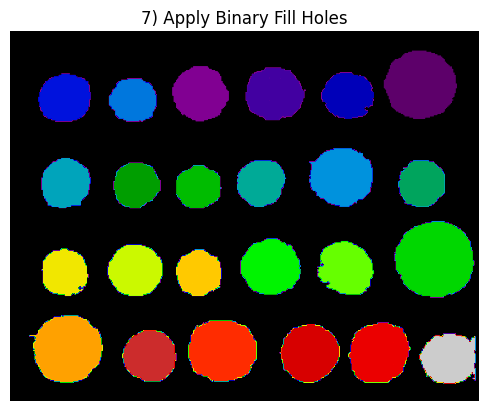

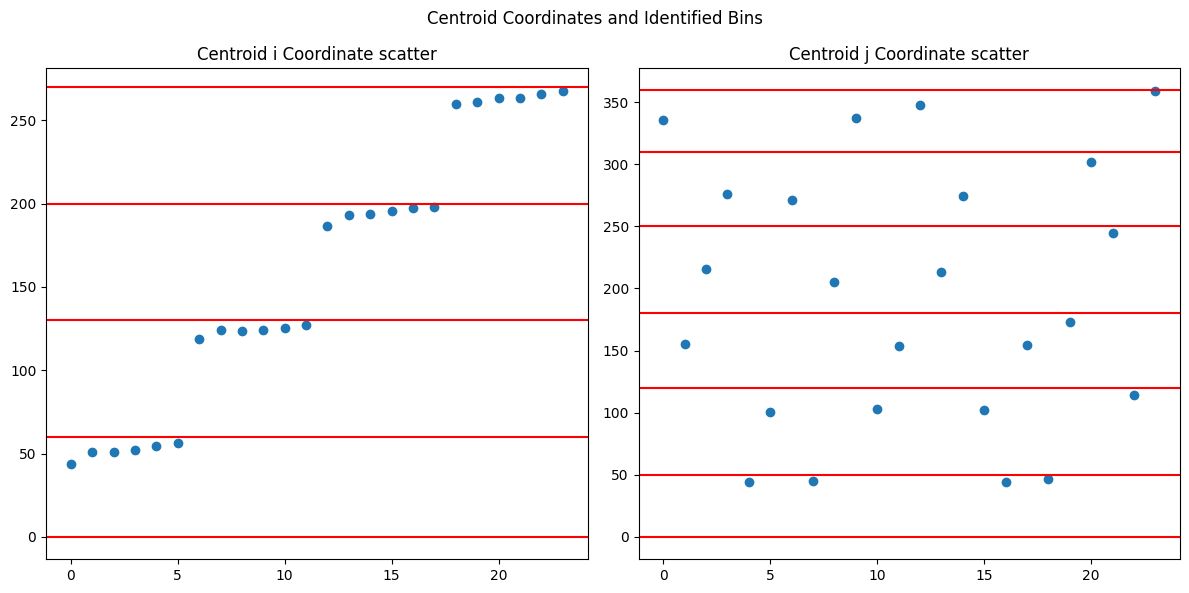

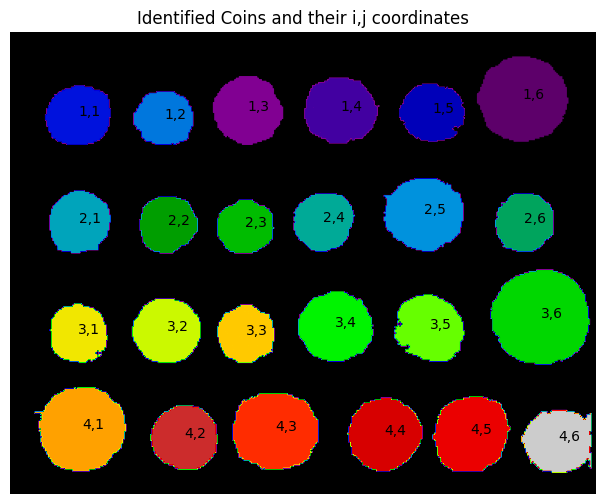

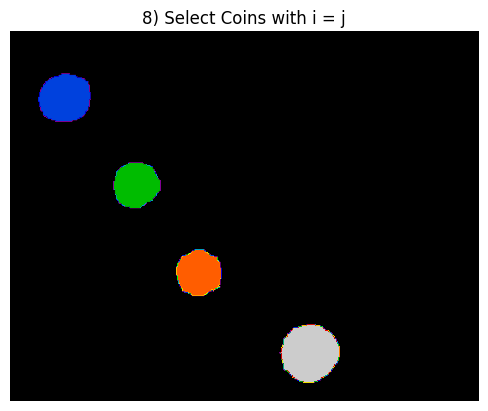

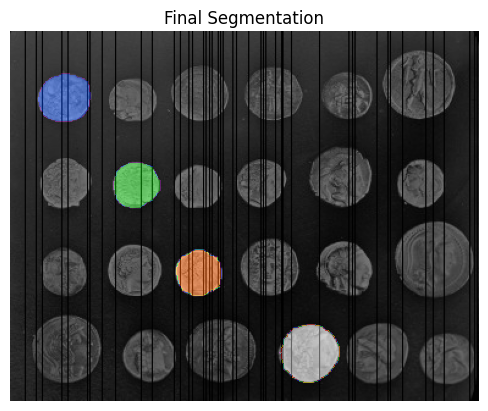

In [8]:
# Load image in grayscale.
image_path = "data/coins.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Segment all the coins.
coin_mask = segment_coins(image)

# Select the coins where row position = column position.
final_mask = select_coin_segs(coin_mask)

# Overlay the final mask on the original image.
plt.imshow(image, cmap="gray")
plt.imshow(final_mask, cmap="nipy_spectral", alpha=0.5)
plt.title("Final Segmentation")
plt.axis("off")
plt.show()

In [36]:
def segment_coins_2(img):
    plt.imshow(img, cmap="gray")
    plt.title("0) Original Image")
    plt.axis("off")
    plt.show()

    # Make a copy to avoid modifying the original image.
    img_copy = img.copy()

    # Median filter the intensity row wise to line artifacts.
    for idx in range(1, image.shape[0]):
        row_filtered = median(img_copy[idx, :], np.ones(10))
        img[idx, :] = row_filtered

    plt.imshow(img, cmap="gray")
    plt.title("1) Row Wise Median Filtered Image")
    plt.axis("off")
    plt.show()

    # Use Canny edge detector on the filtered image.
    edges = cv2.Canny(img, 100, 200)

    # Visualise the the edge detections.
    plt.imshow(edges, cmap="gray")
    plt.title("2) Canny Edge Detection")
    plt.axis("off")
    plt.show()
    
    inverted_edges = ~edges  # Inverting the edges

    # Slight dilation to connect the edges.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    inverted_edges = ~cv2.dilate(edges.astype(np.uint8), kernel, iterations=1)

    plt.imshow(inverted_edges, cmap="gray")
    plt.title("2b) Dilated Inverted Canny Edges")
    plt.axis("off")
    plt.show()

    # Label the connected components.
    labels = label(inverted_edges, connectivity=1)

    # Visualise the connected components.
    plt.imshow(labels, cmap="nipy_spectral")
    plt.title("Connected Components")
    plt.axis("off")
    plt.show()
    
    # Remove the largest connected component (background).
    regions = regionprops(labels)
    region_areas = {region.label: region.area for region in regions}
    largest_component = max(region_areas, key=region_areas.get)
    labels[labels == largest_component] = 0
    
    # Binarise the labels to get the mask.
    mask = np.zeros_like(labels)
    mask[labels > 0] = 1
    
    # Visualise the final mask.
    plt.imshow(mask, cmap="gray")
    plt.title("Mask after removing the largest component")
    plt.axis("off")
    plt.show()
    
    
    # Normalised Edges
    edges = (edges / edges.max()).astype(np.int64)
    
    # Add edges to mask
    mask += edges
    mask[mask>1]=1
    
    plt.imshow(mask, cmap="gray")
    plt.title("Mask + Edges")
    plt.axis("off")
    plt.show()
    
    # Do a morphological closing to connect the coins.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    
    plt.imshow(mask, cmap="gray")
    plt.title("Morphological Closing")
    plt.axis("off")
    plt.show()
    
    
    # Apply row wise median filter to the mask.
    mask_copy = mask.copy()
    for idx in range(1, image.shape[0]):
        row_filtered = median(mask_copy[idx, :], np.ones(10))
        mask[idx, :] = row_filtered
    
    # Apply column wise median filter to the mask.
    mask_copy = mask.copy()
    for idx in range(1, image.shape[1]):
        col_filtered = median(mask_copy[:, idx], np.ones(10))
        mask[:, idx] = col_filtered
    
    plt.imshow(mask, cmap="gray")
    plt.title("Median Filtered Mask")
    plt.axis("off")
    plt.show()
    
    # Get rid of all small connected components.
    labels = label(mask)
    regions = regionprops(labels)
    for region in regions:
        if region.area < 100:
            labels[labels == region.label] = 0
            
    # Visualise the mask after removing small connected components.
    plt.imshow(labels, cmap="nipy_spectral")
    plt.title("Mask after removing small connected components")
    plt.axis("off")
    plt.show()
    return labels  # Returning the modified labels for further use or analysis

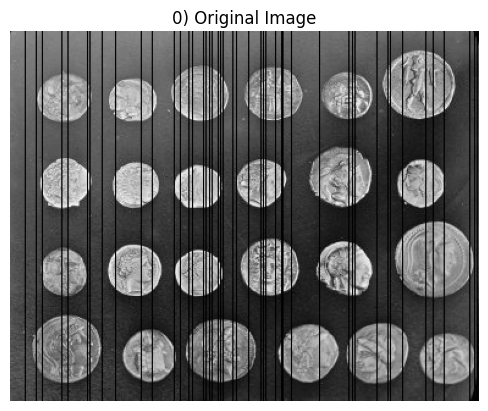

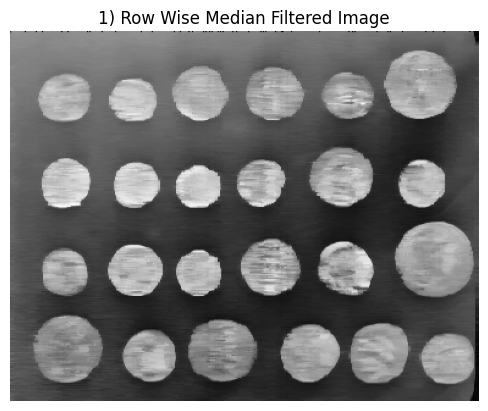

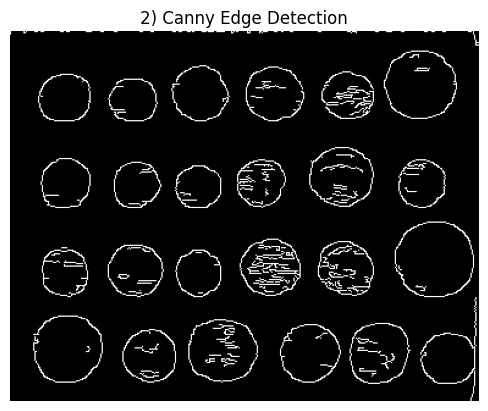

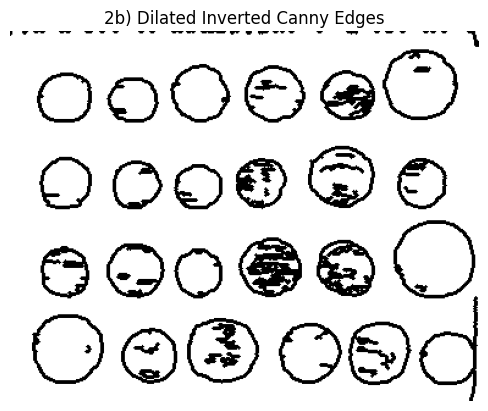

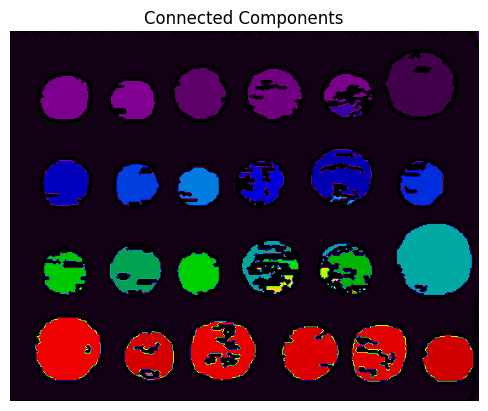

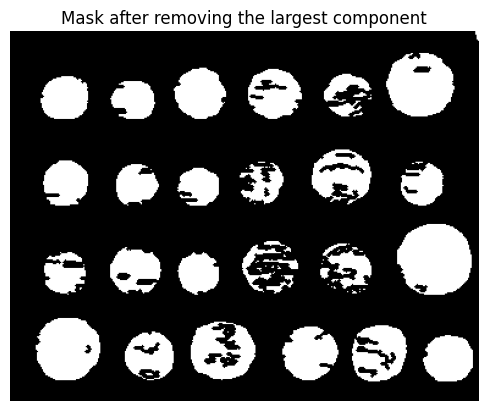

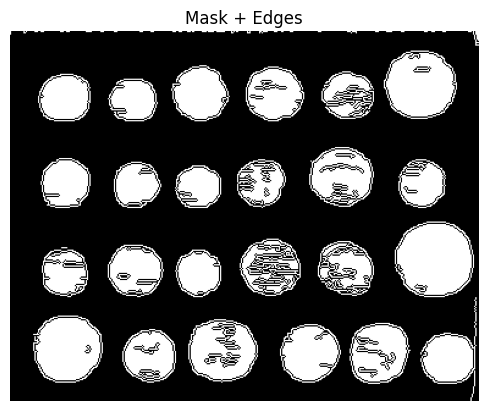

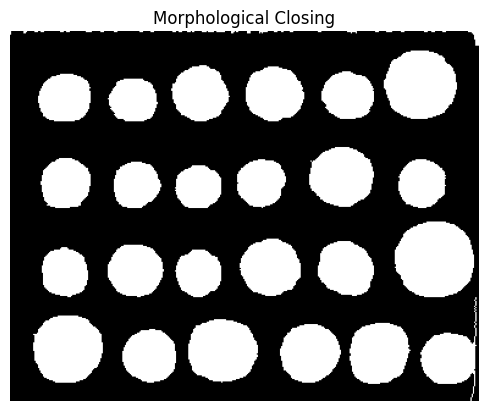

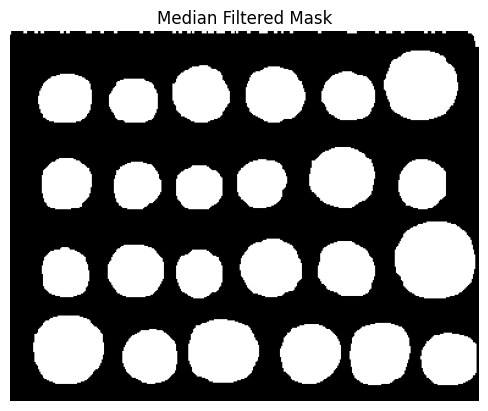

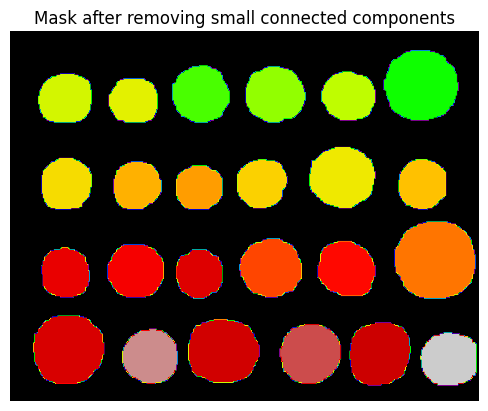

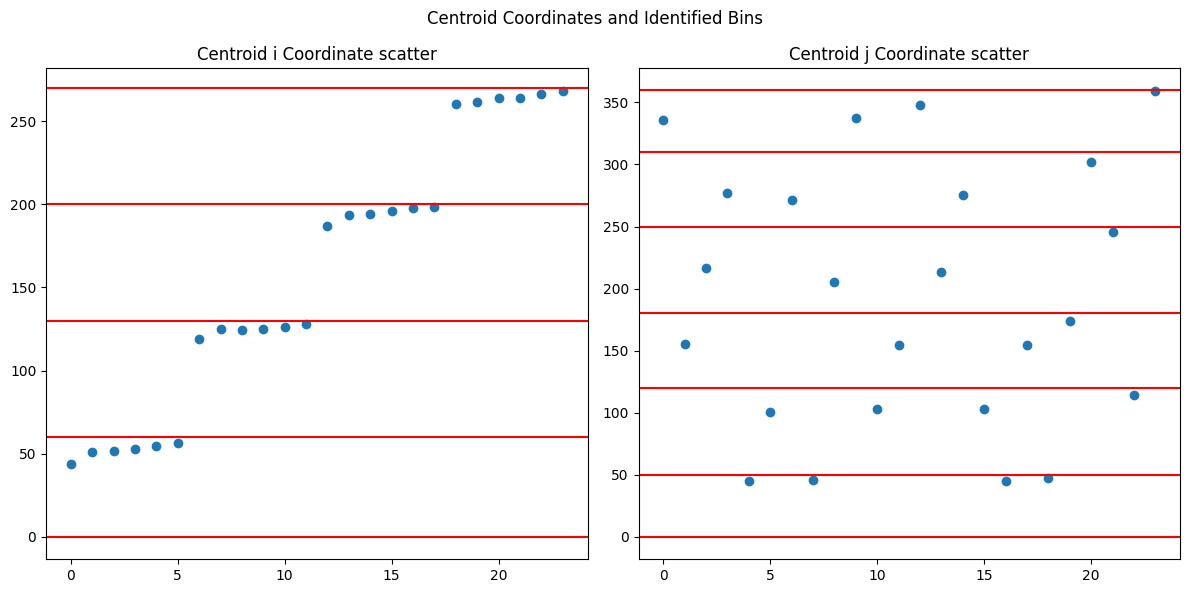

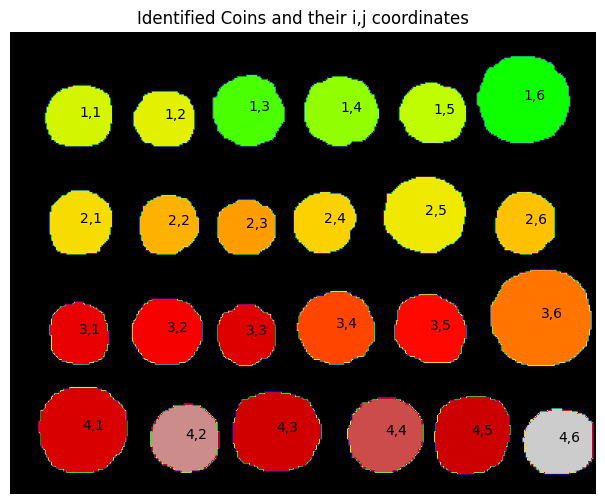

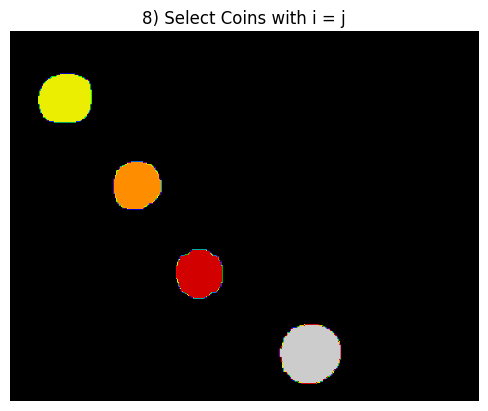

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
from skimage.measure import label, regionprops
from skimage.filters import median
from sklearn.cluster import KMeans
from skimage import io, restoration, color
from icecream import ic


image_path = "data/coins.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Segment all the coins.
coin_mask = segment_coins_2(image)
select_coin_segs(coin_mask)
